## Import Data and Libraries

Mounting the drive on Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


Download the Keras RetinaNet and import libraries

In [2]:
!git clone https://github.com/fizyr/keras-retinanet.git
%cd /content/keras-retinanet/
!pip install .
!python setup.py build_ext --inplace
%cd /content/

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6220, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 6220 (delta 5), reused 6 (delta 2), pack-reused 6205
Receiving objects: 100% (6220/6220), 13.48 MiB | 34.34 MiB/s, done.
Resolving deltas: 100% (4206/4206), done.
/content/keras-retinanet
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/keras-retinanet
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp37-cp37m-linux_x86_64.whl s

In [3]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import urllib.request
import os
import keras
import cv2
import time
import shutil
from google.colab import files
import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%load_ext tensorboard

Extracting the zip file containing the data

In [4]:
with zipfile.ZipFile('/content/drive/MyDrive/Image_Processing_Project/wider-person.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

## Preprocessing

We will use the 1000 validation images for the test set and divide the remaining 8000 ones considering 6000 images for training and 2000 for validation. In order to use the script provided in the [keras-retinanet](https://github.com/fizyr/keras-retinanet) repository, we will need several CSV files:

- '*class.csv*': containing a class name to ID mapping;
- '*train_annotations.csv*': containing annotations for the train set;
- '*val_annotations.csv*': containing annotations for the validation set;
- '*test_annotations.csv*': containing annotations for the test set.

The CSV files with annotations should contain one annotation per line. Images with multiple bounding boxes should use one row per bounding box. Note that indexing for pixel values starts at 0. The expected format of each line is:


```
path/to/image.jpg,x1,y1,x2,y2,class_name
```

The class name to ID mapping file should contain one mapping per line. Each line should use the following format:


```
class_name,id
```





**Creation of 'class.csv'**

As described in the '*ReadMe.txt*' file of the WiderPerson dataset, the class label definition is:
```
class_label = 1: pedestrians
class_label = 2: riders
class_label = 3: partially-visible persons
class_label = 4: ignore regions
class_label = 5: crowd
```
However we will start the count from 0 as required by the ResinaNet implementation.

In [ ]:
classes = pd.DataFrame({'class':['pedestrians','riders','partially-visible persons','ignore regions', 'crowd'],
                        'id': [0,1,2,3,4]})
classes.to_csv('/content/drive/MyDrive/class.csv', index = False, header = False)

**Creation of annotations' CSV files**

The '*ReadMe.txt*' file also describes the format of annotations. Each image of training and valiadation subsets in the "./Images" folder (e.g., 000001.jpg) has a corresponding annotation text file in the "./Annotations" folder (e.g., 000001.jpg.txt). The annotation file structure is in the following format:
```
< number of annotations in this image = N > 
< anno 1 >
< anno 2 >
......
< anno N >
```

So, we will access to these files sequentially and we will manipulate strings to build a *Pandas dataframe* that will be saved into a .csv file having the format required by the keras-retinanet script.

**Train and Validation annotations**

The '*train.txt*' file in the WiderPerson dataset contains the filenames of the 8000 images. We will use this information to access to the files in the folder './Annotations'. All the annotations associated to these 8000 images will be collected into a '*train_and_val_annotations.csv*' file.
Afterwards, this file will be splitted in two different CSVs by extracting 6000 annotations for the train set and 2000 annotations for the validation set.

In [ ]:
# creating an empty dataframe
train_val_annotations = pd.DataFrame(columns = ['path', 'x1', 'y1', 'x2', 'y2', 'class_name'])

In [ ]:
# the dataframe 'train_val_annotations' will be filled in order to contain the annotations for train and validation images
with open('/content/WiderPerson/train.txt', 'r') as train_file: # open 'train.txt' from the WiderPerson dataset
  for filename in train_file: # read the file, line by line. Each line is in the format 'filename\n'. The '\n' character will be excluded by considering filename[:-1]
    with open('/content/WiderPerson/Annotations/' + filename[:-1] + '.jpg.txt', 'r') as annotation_file: # annotations files are named in the format 'filename.jpg.txt'
      for annotation in annotation_file: # each line is one single annotations. Each annotation is in the format: 'class_label x1 y1 x2 y2'
        ann_values = annotation.split() # list containing all the values for the annotation
        if len(ann_values) > 1: # the first line of the file is NOT an annotation. Thus, this control will exlude it.
          # We want the annotations in the .csv file to be in the format 'image_path, x1, y1, x2, y2, class_label'. 
          row_to_append = {'path': '/content/WiderPerson/Images/' + filename[:-1] + '.jpg', 
                          'x1': ann_values[1],
                          'y1': ann_values[2],
                          'x2': ann_values[3],
                          'y2': ann_values[4],
                          'class_name': ann_values[0]}
          train_val_annotations = train_val_annotations.append(row_to_append, ignore_index = True)

Now we can split this file into two.

In [ ]:
# Initialize train and validation dataframes, respectively.
# 'val_annotations' dataframe is initialized as empty.
# 'train_annotations' is initialized as the whole 'train_and_val_annotations' and then elements selected for validation will be popped out. 

val_annotations = pd.DataFrame(columns=["path","x1","y1","x2","y2","class_name"])
train_annotations = train_val_annotations.copy()

In [ ]:
random.seed(2022)

indexes = random.sample(range(8000), 2000) # sample 2000 examples from the train set
unique_path = list(np.unique(np.array(train_annotations["path"]))) # it will create a list containing the path of each image
for index in indexes: # iterate over the selected random indices
  path = unique_path[index] # extract the image path
  val_annotations = val_annotations.append(train_annotations.loc[train_annotations["path"] == path]) # append all the annotations referred to the sampled image to the validation set
  train_annotations = train_annotations.drop(train_annotations.index[train_annotations["path"] == path]) # remove all the annotations of the sampled image from the test set

**Test Annotations**

We will operate in a similar fashion as done above. Filenames will be retrieved by the '*val.txt*' file in the WiderPerson dataset, which contains 1000 filenames of images that will be used as test set.

In [ ]:
test_annotations = pd.DataFrame(columns = ['path', 'x1', 'y1', 'x2', 'y2', 'class_name'])

*Note*: we add a new blank line at the end of the 'val.txt' file for programming reasons.

In [ ]:
# Adding the new line at the end of the text file

file_object = open('/content/WiderPerson/val.txt', 'a') # open the file with access mode 'a'
file_object.write('\n') # Append '\n' at the end of file
file_object.close() # Close the file

In [ ]:
with open('/content/WiderPerson/val.txt', 'r') as test_file:
  for filename in test_file:
    with open('/content/WiderPerson/Annotations/' + filename[:-1] + '.jpg.txt', 'r') as annotation_file:
      for annotation in annotation_file:
        ann_values = annotation.split()
        if len(ann_values) > 1:
          row_to_append = {'path': '/content/WiderPerson/Images/' + filename[:-1] + '.jpg', 
                          'x1': ann_values[1],
                          'y1': ann_values[2],
                          'x2': ann_values[3],
                          'y2': ann_values[4],
                          'class_name': ann_values[0]}
          test_annotations = test_annotations.append(row_to_append, ignore_index = True)

The last step is to convert class labels to class names, as required for the CSVs by the ResinaNet implementation.

In [ ]:
# Map class labels to class names
# 1: pedestrians
# 2: riders
# 3: partially-visible persons
# 4: ignore regions
# 5: crowd

class_names = ['pedestrians', 'riders', 'partially-visible persons', 'ignore regions', 'crowd']
train_class_names = [class_names[label - 1] for label in train_annotations['class_name']]
val_class_names = [class_names[label - 1] for label in val_annotations['class_name']]
test_class_names = [class_names[label - 1] for label in test_annotations['class_name']]

In [ ]:
# Remove the old column with class labels...
train_annotations.pop('class_name')
val_annotations.pop('class_name')
test_annotations.pop('class_name')

# ...and append the new column with class names
train_annotations['class_name'] = train_class_names
val_annotations['class_name'] = val_class_names
test_annotations['class_name'] = test_class_names

**! Additional step !**

During the training phase, we encountered a corrupted training example that caused the following error:

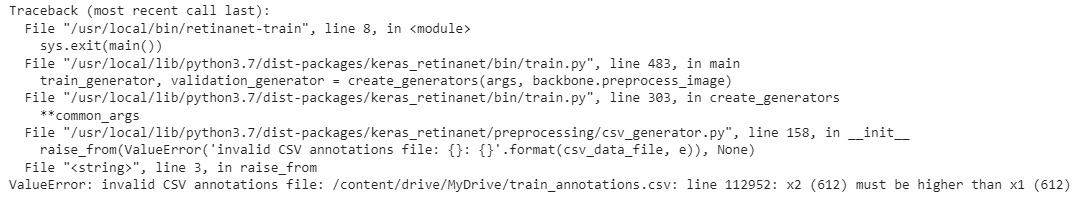

By a simple query to the dataframe, it turns out that the annotation at line **112952** corresponds to the image '*011765.jpg*'. Thus, we simply remove it from the training set.

In [ ]:
train_annotations = train_annotations.drop(train_annotations.index[train_annotations["path"] == '/content/WiderPerson/Images/011765.jpg'])

Save the final results:

In [ ]:
train_annotations.to_csv('/content/drive/MyDrive/train_annotations.csv', index = False, header = False)
val_annotations.to_csv('/content/drive/MyDrive/val_annotations.csv', index = False, header = False)
test_annotations.to_csv('/content/drive/MyDrive/test_annotations.csv', index = False, header = False)

**Class distribution**

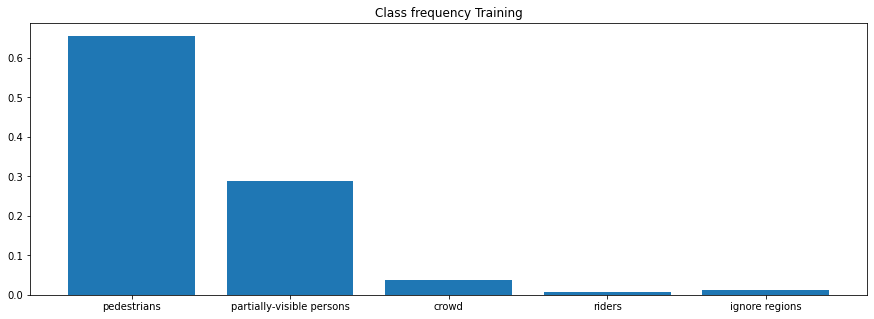

In [ ]:
classes = train_annotations['class_name'].unique()
counts = [train_annotations[train_annotations['class_name'] == a_class].count()[0] for a_class in classes]
counts = counts / sum(counts)

plt.figure(figsize=(15,5))
plt.title('Class frequency Training')
plt.bar(classes, counts)
plt.show()

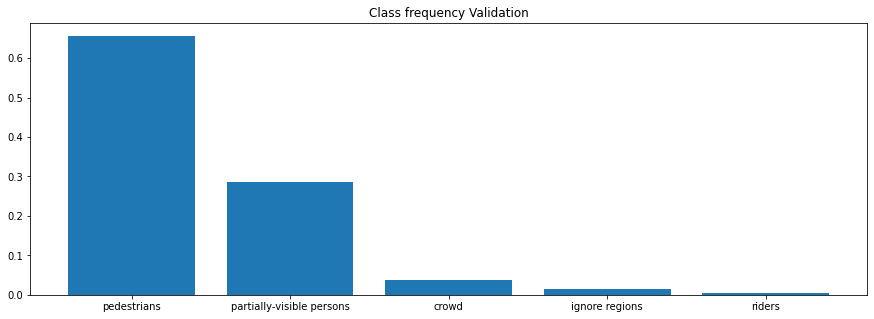

In [ ]:
classes = val_annotations['class_name'].unique()
counts = [val_annotations[val_annotations['class_name'] == a_class].count()[0] for a_class in classes]
counts = counts / sum(counts)

plt.figure(figsize=(15,5))
plt.title('Class frequency Validation')
plt.bar(classes, counts)
plt.show()

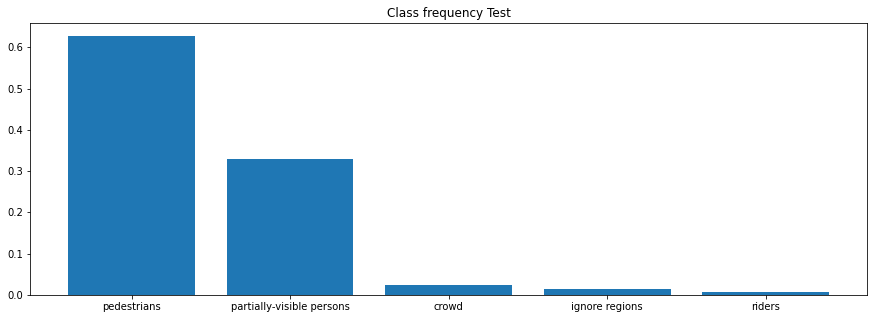

In [ ]:
classes = test_annotations['class_name'].unique()
counts = [test_annotations[test_annotations['class_name'] == a_class].count()[0] for a_class in classes]
counts = counts / sum(counts)

plt.figure(figsize=(15,5))
plt.title('Class frequency Test')
plt.bar(classes, counts)
plt.show()

# Training Phase

We will freeze the training of the backbone. Thus, we download pretrained weights from the repository.

In [ ]:
PRETRAINED_MODEL = './keras-retinanet/snapshots/_pretrained_model.h5'
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL) # the model downloaded from URL_MODEL will be saved in the file path PRETRAINED_MODEL.

('./keras-retinanet/snapshots/_pretrained_model.h5',
 <http.client.HTTPMessage at 0x7f9c0fe35fd0>)

**Fine Tuning**

In order to select the best setting for the model, we performed Fine Tuning by running several different experiments and compared their performances with the use of the visualization tool **Tensorboard**. 

Before performing the tuning, it's worth noting that for each plot the validation loss keeps lower than the training loss.   


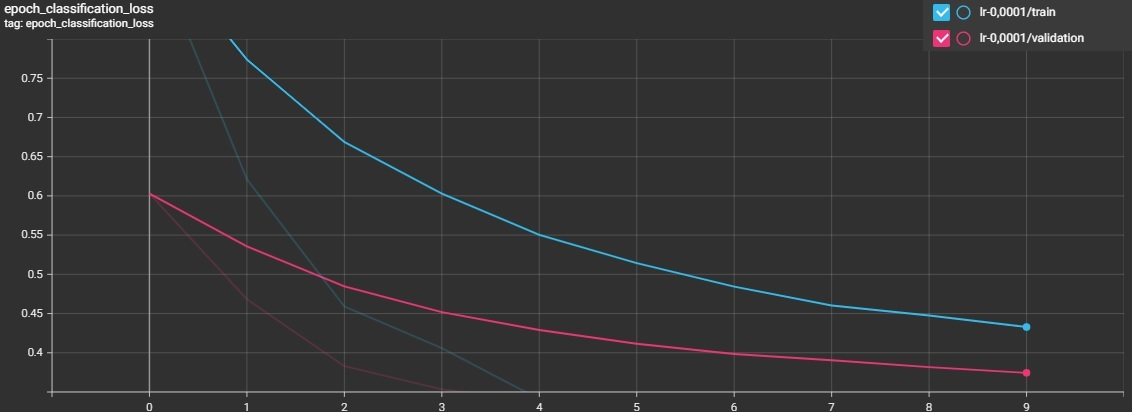

Therefore, we will plot only the validation loss


Tuning - Learning Rate

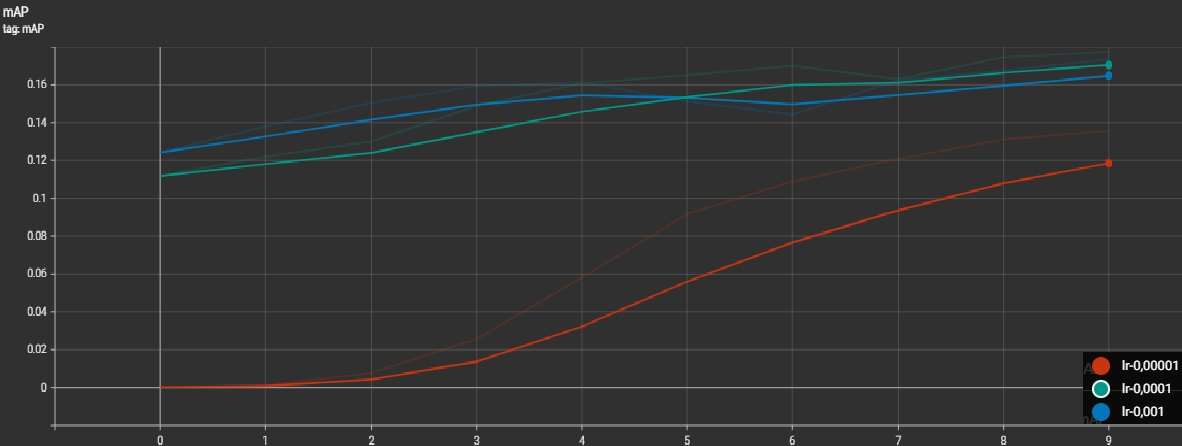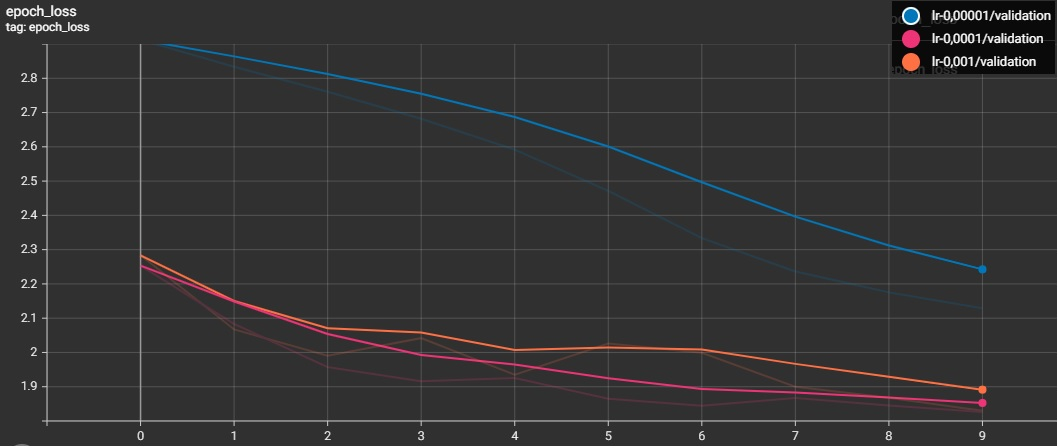

Tuning - Batch Size (lr: 0.0001)

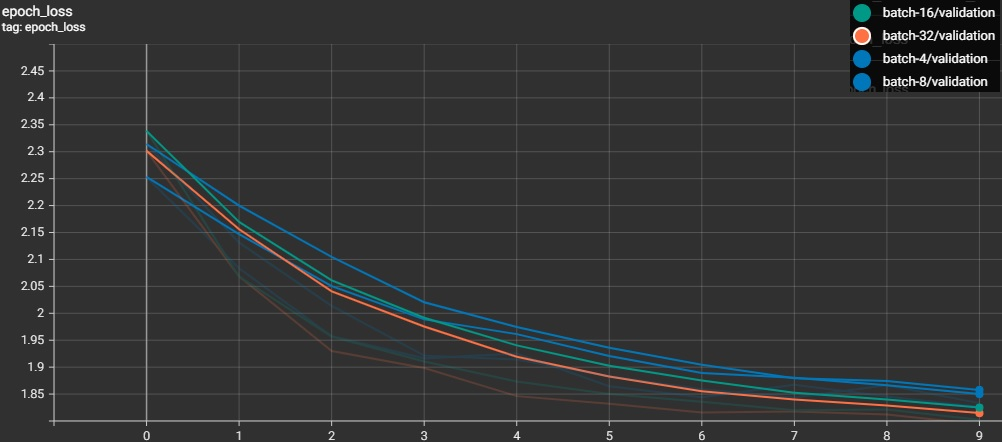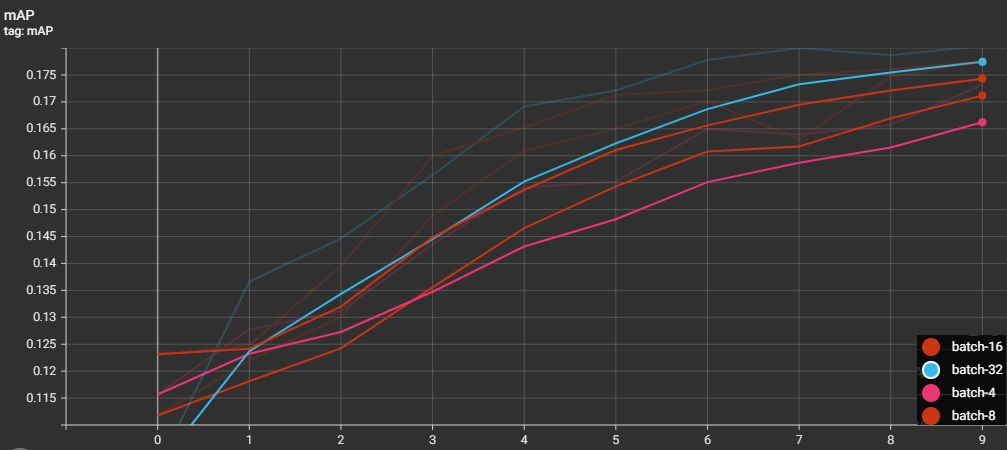

Tuning - number of Epochs (lr: 0.0001, batch_size: 32)

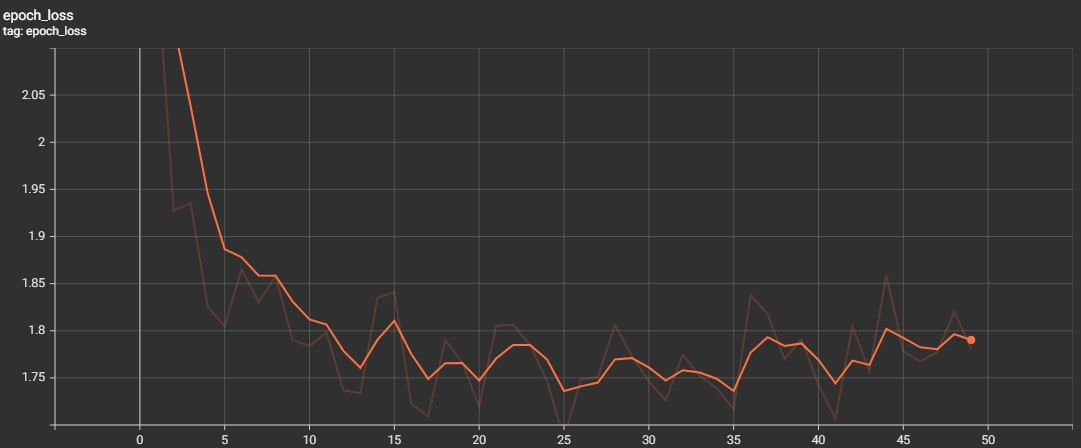

Tuning - augmentation

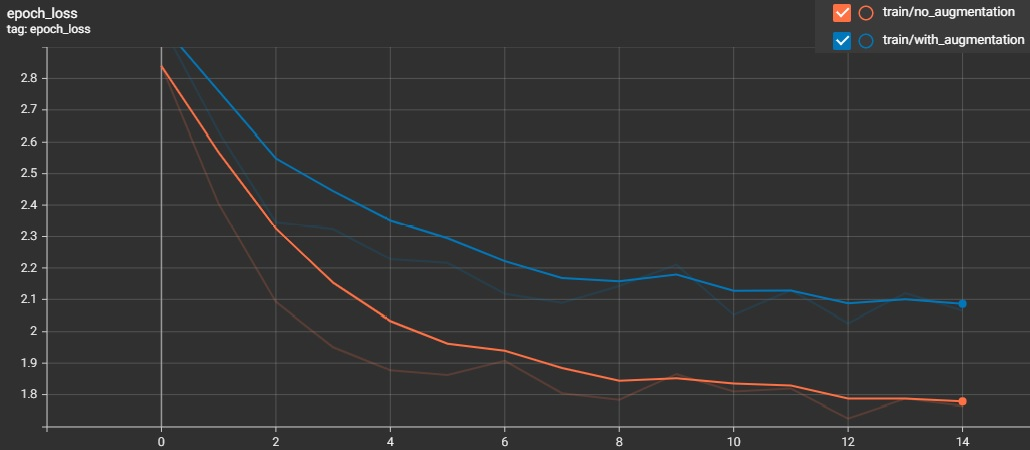

**Training**

Definitive setting
- batch size: 32
- epochs: 15
- steps: 10
- learning rate: 0.0001
- no augmentation

In [ ]:
!python /content/keras-retinanet/keras_retinanet/bin/train.py --backbone resnet50 --freeze-backbone  --weights {PRETRAINED_MODEL} --batch-size 32 --epochs 15 --steps 10 --lr 0.0001 --tensorboard-dir /content/drive/MyDrive/experiments/final_model  csv /content/drive/MyDrive/train_annotations.csv /content/drive/MyDrive/class.csv 
#--compute-val-loss --val-annotations /content/drive/MyDrive/val_annotations.csv 


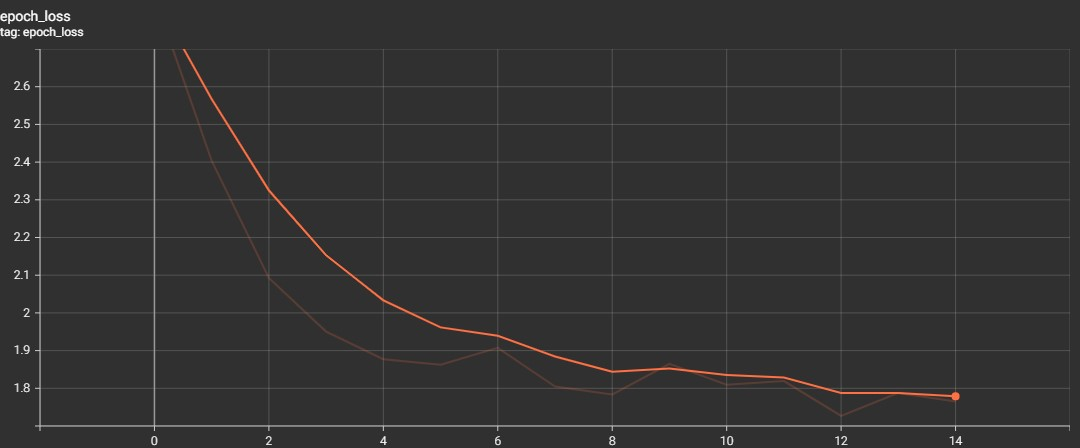

Visualization tool for Tuning

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/experiments/

# Test Phase

Firstly, we need to convert the train model to an inference model

In [ ]:
!python /content/keras-retinanet/keras_retinanet/bin/convert_model.py /content/drive/MyDrive/Image_Processing_Project/model_15_epochs/resnet50_csv_15.h5 /content/drive/MyDrive/Image_Processing_Project/inference_model/inference_resnet50_csv_15.h5

Now we can evaluate the performances on the test set

In [ ]:
!python /content/keras-retinanet/keras_retinanet/bin/evaluate.py --backbone resnet50 csv /content/drive/MyDrive/test_annotations.csv /content/drive/MyDrive/class.csv /content/drive/MyDrive/Image_Processing_Project/inference_model/inference_resnet50_csv_15.h5

Loading model, this may take a second...
2022-06-08 14:40:18.060952: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Running network: 100% (1000 of 1000) |####| Elapsed Time: 0:04:45 Time:  0:04:45
Parsing annotations: 100% (1000 of 1000) || Elapsed Time: 0:00:00 Time:  0:00:00
17833 instances of class pedestrians with average precision: 0.7904
185 instances of class riders with average precision: 0.0023
9335 instances of class partially-visible persons with average precision: 0.2263
409 instances of class ignore regions with average precision: 0.0000
661 instances of class crowd with average precision: 0.0001
Inference time for 1000 images: 0.2525
mAP using the weighted average of precisions among classes: 0.5702
mAP: 0.2038


# Inference phase


Let us build a function that predicts boxes and draws them on the image.

In [5]:
def get_boxes(img_path, class_path, annotation_path = None, thresh = 0.5, ground_truth = False, model_path = None ):
  image = read_image_bgr(img_path)
  
  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  
  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)
  labels_to_names = pd.read_csv(class_path,header=None).T.loc[0].to_dict()

  if ground_truth == True:
    if annotation_path == None:
      print("With ground_truth = True, you need to pass annotation file path")
      return 0
    with open(annotation_path, 'r') as annotation_file:
      i=0
      for annotation in annotation_file:
        ann_values = annotation.split()
        if len(ann_values) == 1:
          num_annotation = int(ann_values[0])
          boxes = np.zeros((1,num_annotation,4))
          labels = np.zeros((1,num_annotation),dtype=int)
        else:
          boxes[:,i,:] = np.array([ann_values[1],ann_values[2],ann_values[3],ann_values[4]])
          labels[:,i] = int(ann_values[0]) - 1
          i+=1
    scores = np.ones((1,num_annotation))

  else:
    if model_path == None:
      print("If ground_truth = False, you need to pass the model_path")
      return 0
    model = models.load_model(model_path, backbone_name='resnet50')
    model = models.convert_model(model)

    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    boxes = boxes / scale

  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # avoid drawing the box if its score is under the threshold
    if score < thresh:
        break

    color = label_color(label)

    b = box.astype(int)
    draw_box(draw, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    print(caption)
    draw_caption(draw, b, caption)
  return draw

In [ ]:
img_name = '001330.jpg'
image_path = '/content/WiderPerson/Images/'+img_name
threshold = 0.5
class_path = '/content/drive/MyDrive/class.csv'
model_path = '/content/drive/MyDrive/Image_Processing_Project/model_15_epochs/resnet50_csv_15.h5'
annotation_path = '/content/WiderPerson/Annotations/' + img_name + '.txt'

draw_ground_truth = get_boxes(img_path = image_path, thresh = threshold, class_path = class_path, ground_truth = True, annotation_path = annotation_path)
print("\n\n")
draw_predicted_boxes = get_boxes(img_path = image_path, thresh = threshold, class_path = class_path, ground_truth = False, model_path = model_path)


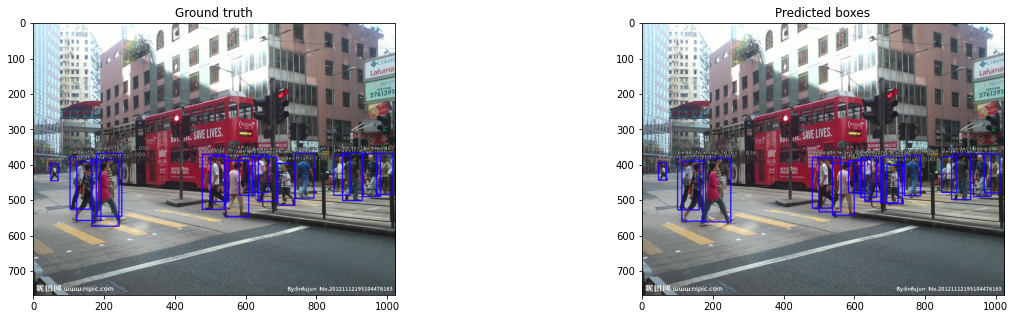

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.title("Ground truth")
plt.imshow(draw_ground_truth)

plt.subplot(1,2,2)
plt.title("Predicted boxes")
plt.imshow(draw_predicted_boxes)
plt.show()

### Test images

Pedestrians and partially visible people

In [6]:
image_path = '/content/drive/MyDrive/Image_Processing_Project/test_images/pedestrian.jpg'
threshold = 0.5
class_path = '/content/drive/MyDrive/class.csv'
model_path = '/content/drive/MyDrive/Image_Processing_Project/model_15_epochs/resnet50_csv_15.h5'
draw_predicted_boxes = get_boxes(img_path = image_path, thresh = threshold, class_path = class_path, ground_truth = False, model_path = model_path)


pedestrians 0.897
pedestrians 0.892
pedestrians 0.882
pedestrians 0.853
pedestrians 0.831
pedestrians 0.793
pedestrians 0.582
partially-visible persons 0.536
partially-visible persons 0.506


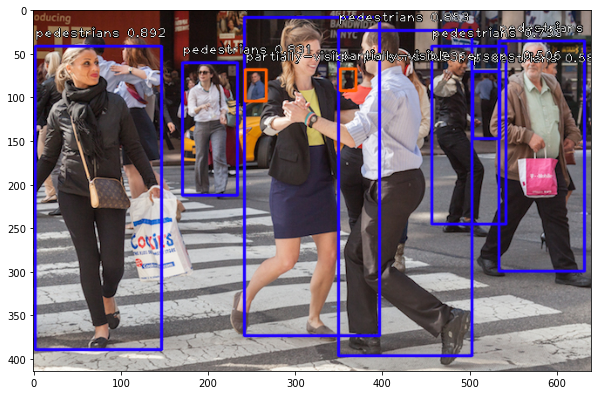

In [7]:
plt.figure(figsize = (10,10))
plt.imshow(draw_predicted_boxes)
plt.show()

Riders - they are not detected

In [8]:
image_path = '/content/drive/MyDrive/Image_Processing_Project/test_images/bikes.jpg'
threshold = 0.5
class_path = '/content/drive/MyDrive/class.csv'
model_path = '/content/drive/MyDrive/Image_Processing_Project/model_15_epochs/resnet50_csv_15.h5'
draw_predicted_boxes = get_boxes(img_path = image_path, thresh = threshold, class_path = class_path, ground_truth = False, model_path = model_path)


pedestrians 0.596
pedestrians 0.567


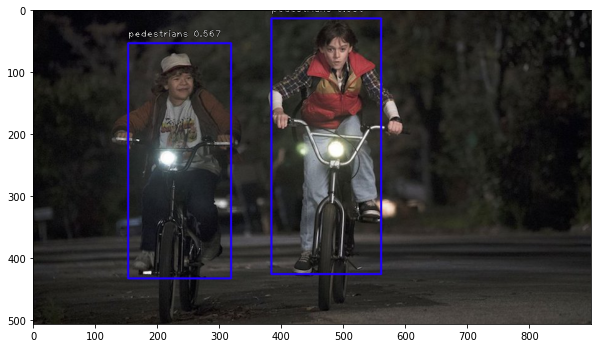

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(draw_predicted_boxes)
plt.show()

Partially visible people (occluded by us)

In [ ]:
image_path = '/content/drive/MyDrive/Image_Processing_Project/test_images/ped.jpg'
threshold = 0.4
class_path = '/content/drive/MyDrive/class.csv'
model_path = '/content/drive/MyDrive/Image_Processing_Project/model_15_epochs/resnet50_csv_15.h5'
draw_predicted_boxes = get_boxes(img_path = image_path, thresh = threshold, class_path = class_path, ground_truth = False, model_path = model_path)


partially-visible persons 0.564


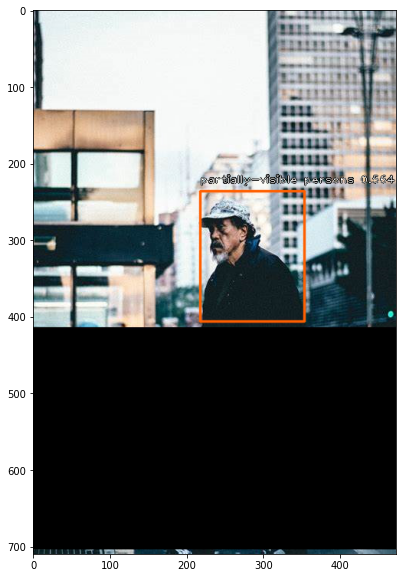

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(draw_predicted_boxes)
plt.show()

In [ ]:
image_path = '/content/drive/MyDrive/Image_Processing_Project/test_images/peddd.jpg'
threshold = 0.4
class_path = '/content/drive/MyDrive/class.csv'
model_path = '/content/drive/MyDrive/Image_Processing_Project/model_15_epochs/resnet50_csv_15.h5'
draw_predicted_boxes = get_boxes(img_path = image_path, thresh = threshold, class_path = class_path, ground_truth = False, model_path = model_path)


pedestrians 0.565


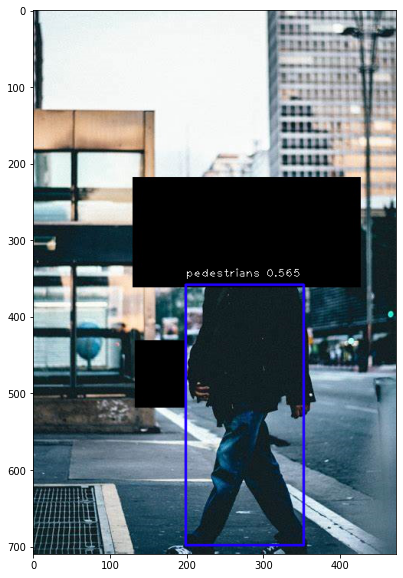

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(draw_predicted_boxes)
plt.show()

# Different backbones

In [ ]:
PRETRAINED_MODEL = './keras-retinanet/snapshots/_pretrained_model.h5'
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet152_oid_v1.0.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL) # the model downloaded from URL_MODEL will be saved in the file path PRETRAINED_MODEL.

('./keras-retinanet/snapshots/_pretrained_model.h5',
 <http.client.HTTPMessage at 0x7ff644b627d0>)

In [ ]:
!python /content/keras-retinanet/keras_retinanet/bin/train.py --backbone resnet152 --freeze-backbone --weights {PRETRAINED_MODEL} --batch-size 32 --epochs 15 --steps 10 --lr 0.0001 --tensorboard-dir /content/drive/MyDrive/experiments/backbones/resnet_152  csv /content/drive/MyDrive/train_annotations.csv /content/drive/MyDrive/class.csv 
#--compute-val-loss --val-annotations /content/drive/MyDrive/val_annotations.csv 

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/experiments/backbones

Backbone performance on training set  

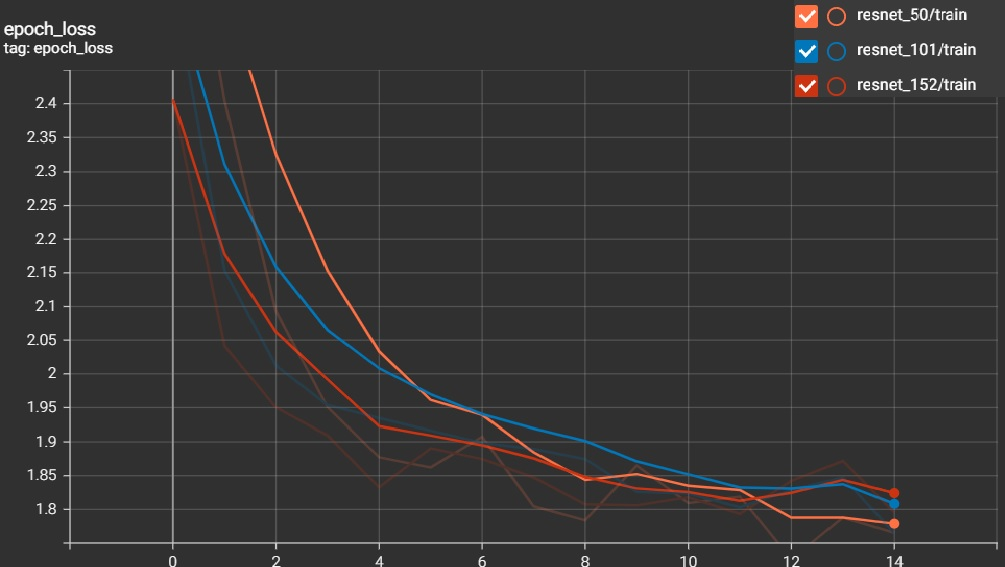